In [1]:
## Reload the modules each time there are modified
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import src as mpmab

## 1. Create a Multi-armed-Bandit (MAB) environment
Different arm classes are defined in `arms.py`. All arms can be sampled using the `sample` method. 

In [3]:
arm = mpmab.Bernoulli(0.7)
print(f"The mean of the arm is     {arm.mean}.")
print(f"The variance of the arm is {arm.variance:.2f}.")
print(f"A sample from the arm is   {arm.sample()}.")

The mean of the arm is     0.7.
The variance of the arm is 0.21.
A sample from the arm is   1.0.


The kullback-Leibler divergence for each distribution is available through the `kl` class-method. (Moreover `kl_ucb` class-method computes the kl-UCB indices.)

In [4]:
print(f"Compute the KL divergence using the arm class {mpmab.Bernoulli.kl(0.5, 1):.2f}.")
print(f"Compute the KL divergence using an instance   {arm.kl(0.5, 1):.2f}.")

Compute the KL divergence using the arm class 16.58.
Compute the KL divergence using an instance   16.58.


A MAB environment is then wrapped in `MAB` class, which take a list of arms as an input. Other subclasses defines some particular `MAB` intances such as `BernoulliMAB`. 

In [7]:
bandit = mpmab.BernoulliMAB([0.3, 0.4, 0.5, 0.6, 0.7])
print("Mean rewards of the arms:", bandit.means)
print("2 best means are:", bandit.m_best_arms_means(2))
print("Generate reward from arm #2:", bandit.generate_reward(2))

Mean rewards of the arms: [0.3 0.4 0.5 0.6 0.7]
2 best means are: [0.7 0.6]
Generate reward from arm #2: 1.0


## 2. Playing a Multi-Players bandit strategy
Individual strategies (`PlayerRandTop`, `PlayerMCTop`, `PlayerSelfish`) are defined in `src/strategies`, and comes with two important methods:
* `choose_arm_to_play()`: select the next arm to play
* `receive_reward(reward, collision)`: update the strategy when the chosen arm produced the reward `reward` and a collision occured (or not).

To define a set of players with the same stragey, you can use the simple function `strategy`, that takes the individual strategy, the number of arms, the number of players as input. Optional parameters are used to define the individual strategy. For instance all individual strategies defined yet are based on *index policies*. These policies such as `UCB1Policy` or `KlUCBPolicy` are provided in `src/index_policies`.

In [8]:
nb_players, nb_arms = 3, bandit.nb_arms
strategy = mpmab.strategy(mpmab.PlayerRandTop, nb_arms, nb_players, policy=mpmab.UCB1Policy(0.5))

`MultiplayerEnv` provides a convenient way to run the strategy on a particular bandit environment until a given time_horizon. Thus the whole history of selections, collisions, sensing informations (rewards produced by the arms), rewards (rewards actually received by the players) are thus stores as attributes / properties of the experiment.

In [9]:
exp = mpmab.MultiplayerExp(bandit, strategy, time_horizon=200)
exp.run()

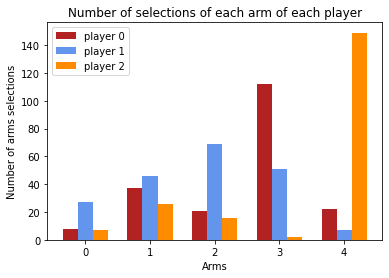

In [10]:
plt.hist(exp.selections.T, range=(0, nb_arms),bins=nb_arms,
    align="left", histtype='bar', rwidth=0.7,
    color=["firebrick", "cornflowerblue", "darkorange"],
    label=[f"player {j}" for j in range(nb_players)])

plt.xticks(range(nb_arms))
plt.xlabel("Arms")
plt.ylabel("Number of arms selections")
plt.title("Number of selections of each arm of each player")
plt.legend()
plt.show()

An interactive display of the arm selections history can be obtained using the `animate` method:

In [11]:
from IPython.display import HTML

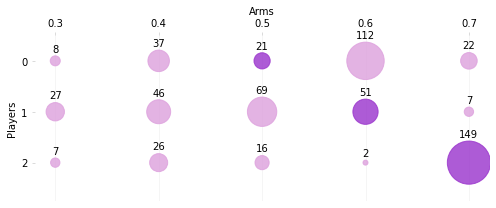

In [19]:
anim = exp.animate()
# anim.save(f"img/{exp.players[0].name()}_M{nb_players}_K{nb_arms}.gif", writer='imagemagick')  # Uncomment to save the animation as a gif

In [18]:
HTML(anim.to_jshtml())

## 3. Evaluate a strategy
The function `multiple_runs` runs multiple times an experiment and outputs the expected cumulative regret (using a regret decomposition expression).

In [13]:
cum_regret, end_regrets = mpmab.multiple_runs(exp, N_exp=200, return_end_regrets=True)

200/200 [====================] (100%)

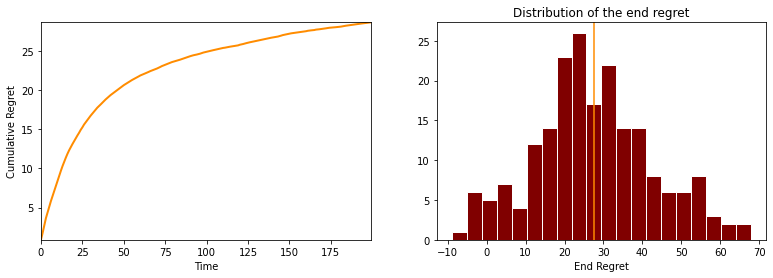

In [18]:
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.plot(cum_regret, lw=2, color="darkorange")
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.margins(0)

plt.subplot(122)
plt.hist(end_regrets, bins=20, edgecolor="white", color="maroon")
plt.axvline(end_regrets.mean(), color="darkorange")
plt.title("Distribution of the end regret")
plt.xlabel("End Regret")
plt.show()